In [ ]:
import pandas as pd
import numpy as np
import glob
import seaborn as sns
from poker_embeddings.models.card import CardGNN
import torch
import torch.nn.functional as F
from sklearn.manifold import TSNE
from poker_embeddings.poker_utils.constants import DECK_DICT
import matplotlib.pyplot as plt
from poker_embeddings.poker_utils.hands import create_deck_graph, query_subgraph
from poker_embeddings.poker_utils.hands import _card_to_idx
from torch_geometric.data import Data, Batch

In [2]:
loss_data = []
for path in glob.glob("../training_results/**/*train_loss*", recursive=True):
    dat = pd.read_csv(path)
    loss_data.append(dat)
loss_data = pd.concat(loss_data)

<Axes: xlabel='epochs', ylabel='train_accuracy'>

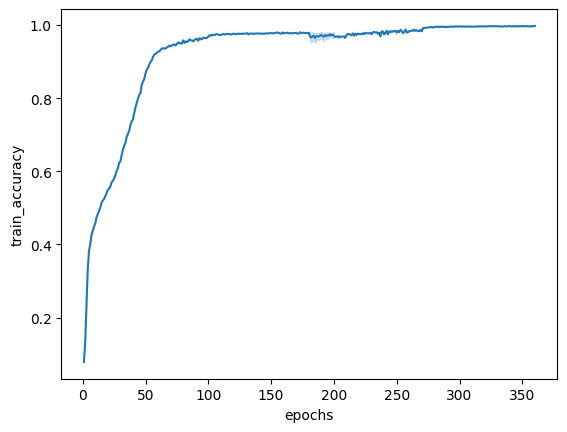

In [3]:
sns.lineplot(data=loss_data, x='epochs',y='train_accuracy')

In [4]:
report = pd.read_csv("../training_results/hand_rank_predictor/run3/hand_rank_predictor_classification_report_360.csv")
cm = pd.read_csv("../training_results/hand_rank_predictor/run3/hand_rank_predictor_confusion_matrix_360.csv")

In [5]:
print(report)

              class  precision    recall  f1-score        support
0           nothing   0.999961  0.994935  0.997442  308221.000000
1          one_pair   0.999996  0.997018  0.998505  259858.000000
2          two_pair   1.000000  0.999556  0.999778   29297.000000
3   three_of_a_kind   0.999923  0.999461  0.999692   12980.000000
4          straight   0.504570  0.994554  0.669487    2387.000000
5             flush   0.980064  0.999187  0.989533    1230.000000
6        full_house   1.000000  1.000000  1.000000     876.000000
7    four_of_a_kind   1.000000  1.000000  1.000000     142.000000
8    straight_flush   0.666667  1.000000  0.800000      10.000000
9       royal_flush   0.000000  0.000000  0.000000       5.000000
10         accuracy   0.996138  0.996138  0.996138       0.996138
11        macro avg   0.815118  0.898471  0.845444  615006.000000
12     weighted avg   0.998001  0.996138  0.996754  615006.000000


In [6]:
cm

,class,High Card,Pair,Two Pair,Three of a Kind,Straight,Flush,Full House,Four of a Kind,Straight Flush,Royal Flush
0,High Card,306660,0,0,0,1543,18,0,0,0,0
1,Pair,0,259083,0,1,768,6,0,0,0,0
2,Two Pair,0,0,29284,0,13,0,0,0,0,0
3,Three of a Kind,0,0,0,12973,7,0,0,0,0,0
4,Straight,12,1,0,0,2374,0,0,0,0,0
5,Flush,0,0,0,0,0,1229,0,0,1,0
6,Full House,0,0,0,0,0,0,876,0,0,0
7,Four of a Kind,0,0,0,0,0,0,0,142,0,0
8,Straight Flush,0,0,0,0,0,0,0,0,10,0
9,Royal Flush,0,0,0,0,0,1,0,0,4,0


In [44]:
model = CardGNN().eval()
model.load_state_dict(torch.load("../model_weights/hand_rank_predictor/hand_rank_predictor360.pth", weights_only=True))

<All keys matched successfully>

In [46]:
with torch.no_grad():
    card_embeddings = model.card_embedder.weight
    card_embeddings = model.card_emb_projector(card_embeddings).cpu()
    card_embeddings_norm = F.normalize(card_embeddings, p=2, dim=1).numpy()

In [47]:
tsne = TSNE(n_components=2, perplexity=30, max_iter=300, random_state=29)
emb_2d = tsne.fit_transform(card_embeddings_norm)

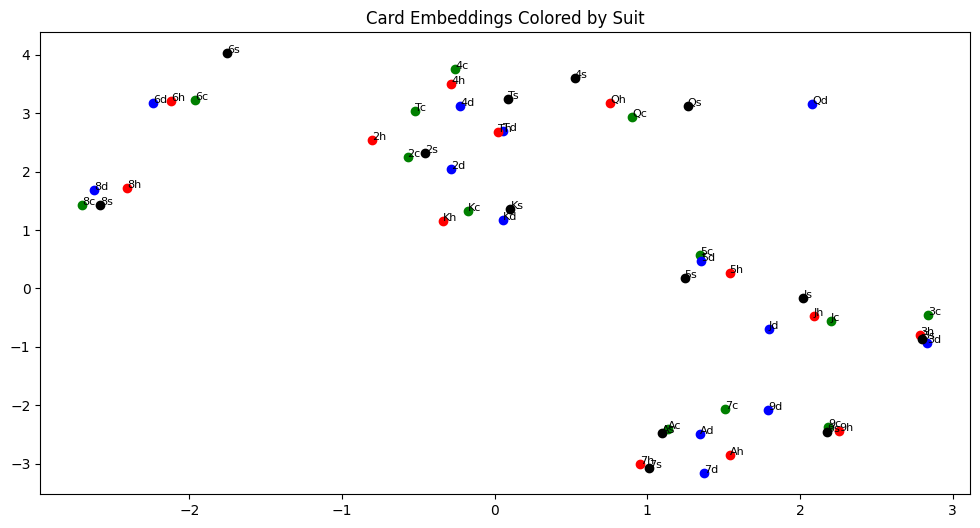

In [48]:

suit_colors = {
    0: 'green', # Clubs
    1: 'blue', # Diamonds
    2: 'red', # Hearts
    3: 'black' # Spades
}
colors = [suit_colors[i % 4] for i in range(len(DECK_DICT))]

plt.figure(figsize=(12, 6))
for i, txt in DECK_DICT.items():
    if i == 52:
        continue
    plt.scatter(emb_2d[i, 0], emb_2d[i, 1], color=suit_colors[i % 4])
    plt.annotate(txt, (emb_2d[i, 0], emb_2d[i, 1]), fontsize=8)

plt.title("Card Embeddings Colored by Suit")
plt.show()

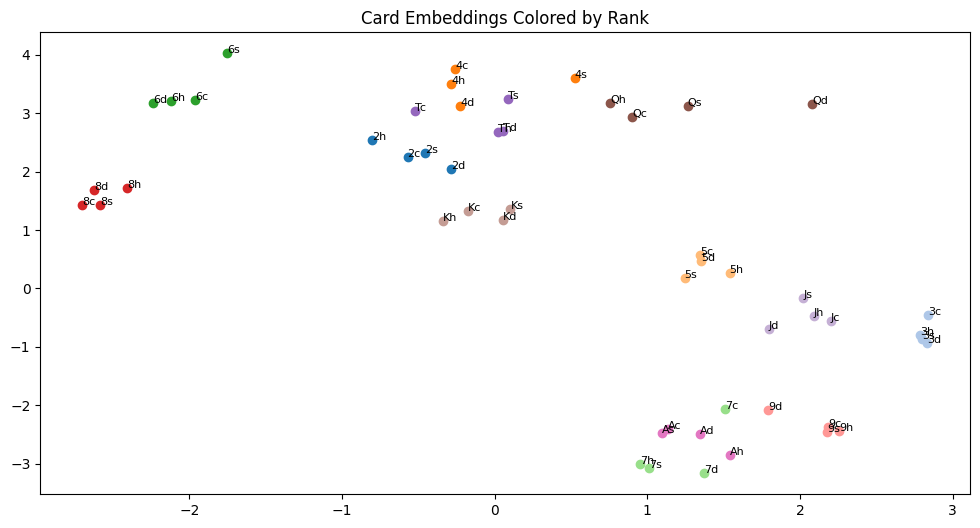

In [49]:
rank_colors = plt.colormaps.get_cmap('tab20')
colors = [rank_colors(i // 4) for i in range(len(DECK_DICT))]
plt.figure(figsize=(12, 6))
for i, txt in DECK_DICT.items():
    if i == 52:
        continue
    plt.scatter(emb_2d[i, 0], emb_2d[i, 1], color=rank_colors(i // 4))
    plt.annotate(txt, (emb_2d[i, 0], emb_2d[i, 1]), fontsize=8)

plt.title("Card Embeddings Colored by Rank")
plt.show()

In [51]:
deck_graph_edge_index, deck_graph_edge_attr = create_deck_graph()

In [100]:
def predict(hands, model, return_logits=True):
    class_names = [
        "high_card", "one_pair", "two_pair", "three_of_a_kind", "straight",
        "flush", "full_house", "four_of_a_kind", "straight_flush", "royal_flush"
        ]
    deck_graph_edge_index, deck_graph_edge_attr = create_deck_graph()
    if isinstance(hands, torch.Tensor):
        if hands.dim() == 1:
            hand_edge_index, hand_edge_attr = query_subgraph(hands, deck_graph_edge_index, deck_graph_edge_attr)
            graph = Data(x=hands, edge_index=hand_edge_index, edge_attr=hand_edge_attr)
            graph = Batch.from_data_list([graph])
        else:
            graphs = []
            for hand in hands:
                hand_edge_index, hand_edge_attr = query_subgraph(hand, deck_graph_edge_index, deck_graph_edge_attr)
                graph = Data(x=hand, edge_index=hand_edge_index, edge_attr=hand_edge_attr)
                graphs.append(graph)
            graph = Batch.from_data_list(graphs)

    elif isinstance(hands, list) and all(isinstance(hand, list) for hand in hands):
        graphs = []
        for hand in hands:
            if isinstance(hand[0], str):
                hand = torch.tensor([_card_to_idx[card] for card in hand])
            else:
                hand = torch.tensor(hand)
            hand_edge_index, hand_edge_attr = query_subgraph(hand, deck_graph_edge_index, deck_graph_edge_attr)
            graph = Data(x=hand, edge_index=hand_edge_index, edge_attr=hand_edge_attr)
            graphs.append(graph)
        graph = Batch.from_data_list(graphs)
    with torch.no_grad():
        logits = model(graph)
    if return_logits:
        return logits
    else:
        preds = logits.argmax(dim=1)
        return [class_names[i.item()] for i in preds]


In [106]:
cards = [
    ['As','Ad','Tc','7c'],
    ['As','Ad','Tc','7c','Ac'],
    ['7h','8h','3s','Th',"Qh","Jh"],
    ['Th','Jh',"Qs","As","Kc"]
    ]
predict(cards, model, return_logits=False)

['one_pair', 'three_of_a_kind', 'flush', 'straight']